In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
import GCRCatalogs
from GCR import GCRQuery
import statistics
import os, sys
import healpy as hp
from tqdm.auto import tqdm, trange
import scipy.stats
import FoFCatalogMatching
import pandas as pd
from astropy.coordinates import SkyCoord
from scipy.stats import pearsonr
import warnings

In [2]:
warnings.filterwarnings('ignore')

### Z and mag filters :

In [3]:
# mag filters :

object_mag_filters = ['mag_i_cModel < 26.5', 'mag_i_cModel > 18',
    (np.isfinite, 'mag_i_cModel'), (np.isfinite, 'mag_r_cModel'), (np.isfinite, 'mag_z_cModel')]

truth_mag_filters = ['mag_i<28','mag_i>18',(np.isfinite, 'mag_i'), (np.isfinite, 'mag_r'), (np.isfinite, 'mag_z')]

### CosmoDC2 and DC2Objects (truth and object) :

In [4]:
import GCRCatalogs
cosmodc2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image') #truth catalog
dc2 = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_with_addons') #object catalog

In [5]:
cosmodc2.get_quantity_info('is_central')

In [6]:
#data object catalog :

object_quantities = ['ra', 'dec', 'mag_i_cModel', 'photoz_mean']

object_data = (dc2.get_quantities(object_quantities,
                                 filters=['extendedness>0', 'clean']+object_mag_filters,
                                 native_filters=['tract==4026']))

print(type(object_data))

<class 'dict'>


In [7]:
# data truth catalog :

eps = 10/3600 # 10 arcsec
max_ra = np.nanmax(object_data['ra']) + eps
min_ra = np.nanmin(object_data['ra']) - eps
max_dec = np.nanmax(object_data['dec']) + eps
min_dec = np.nanmin(object_data['dec']) - eps
pos_filters = [f'ra >= {min_ra}',f'ra <= {max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
healpix_filter = GCRQuery((lambda h: np.isin(h, ipix, True), "healpix_pixel"))

In [8]:
truth_quantities = ['galaxy_id', 'ra', 'dec', 'mag_i', 'redshift', 'is_central', 'halo_mass', 'halo_id']

truth_data = (cosmodc2.get_quantities(truth_quantities, 
                                      filters=truth_mag_filters+pos_filters, 
                                      native_filters=healpix_filter))

In [9]:
print("nombre de galaxies =", len(truth_data['ra']))
print("nombre de galaxies centrales =", len(np.where(truth_data['is_central']==True)[0]))
print("pourcentage de galaxies centrales =", (len(np.where(truth_data['is_central']==True)[0])/len(truth_data['ra']))*100, '%')
print("nombre d'objets =", len(object_data['ra']))

nombre de galaxies = 2920943
nombre de galaxies centrales = 2669420
pourcentage de galaxies centrales = 91.38897951791596 %
nombre d'objets = 676713


### FoF algo :

In [10]:
my_linking_length = 0.4 #linking_lenghts in arcseconds optimal, for 18<mag<26.5

In [11]:
results = FoFCatalogMatching.match(catalog_dict={'object':pd.DataFrame(object_data), 
                                                 'galaxy':pd.DataFrame(truth_data)},
                                                  linking_lengths=my_linking_length)

In [12]:
# first we need to know which rows are from the truth catalog and which are from the object

truth_mask = results['catalog_key'] == 'galaxy'
object_mask = ~truth_mask

In [13]:
# np.bincount will give up the number of id occurrences (like histogram but with integer input)

n_groups = results['group_id'].max() + 1   #nombre de groupes total (groupe/objet)
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)  # groupe de galaxies
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)  # groupe d'objets

print(results['group_id'].max())

2852652


In [14]:
print('total nbr of groups = ', n_groups)
print('nbr of group with at list 1 galaxies = ', len(n_truth[n_truth>0]), "(", (len(n_truth[n_truth>0])/n_groups)*100, '%)')
print('nbr of group with at list 1 object =', len(n_object[n_object>0]), "(", (len(n_object[n_object>0])/n_groups)*100, '%)')

total nbr of groups =  2852653
nbr of group with at list 1 galaxies =  2822154 ( 98.9308548919199 %)
nbr of group with at list 1 object = 676675 ( 23.72090121020678 %)


#### Galaxy central selection :

In [15]:
ind_galax=np.array(results[truth_mask][:]['row_index'])  #transfo dictio astropy en array pour pouvoir indexer en gardant l'ordre des indices donné dans results (relié au group_id)

In [16]:
ind_galax_central = truth_data['is_central'][ind_galax]  #donne indices des galaxies centrales dans l'ordre de results (par groupe_id)

In [17]:
n_truth_central=np.bincount(results[truth_mask][ind_galax_central]['group_id'], minlength=n_groups)  #donne nbr groupe de galaxies cenrtales et leurs id sur la len de n_group

In [18]:
print('nbr of group with at list 1 central galaxies = ', len(n_truth_central[n_truth_central>0]), "(", (len(n_truth[n_truth_central>0])/n_groups)*100, '%)')

nbr of group with at list 1 central galaxies =  2589936 ( 90.7904326253491 %)


Normalised histogram. When we remove satellite galaxies, we can observe a small increase in unrelated object.  

### Satellite galaxies selection :

In [19]:
ind_galax_sat = ~ind_galax_central  #donne indices des galaxies satellites dans l'ordre de results (par groupe_id)

# Halo_mass + z max cut :

In [20]:
truth_data_halo_mass= truth_data['halo_mass'][ind_galax]

truth_data_z= truth_data['redshift'][ind_galax]

In [21]:
halo_mass_cut=5*1e13

z_max_cut= 1.5

## Halo_mass >1e13 + z-max-cut study for all galaxies :

In [22]:
n_truth_2cut_all = np.bincount(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut))[0]]['group_id'],
                               minlength=n_groups)

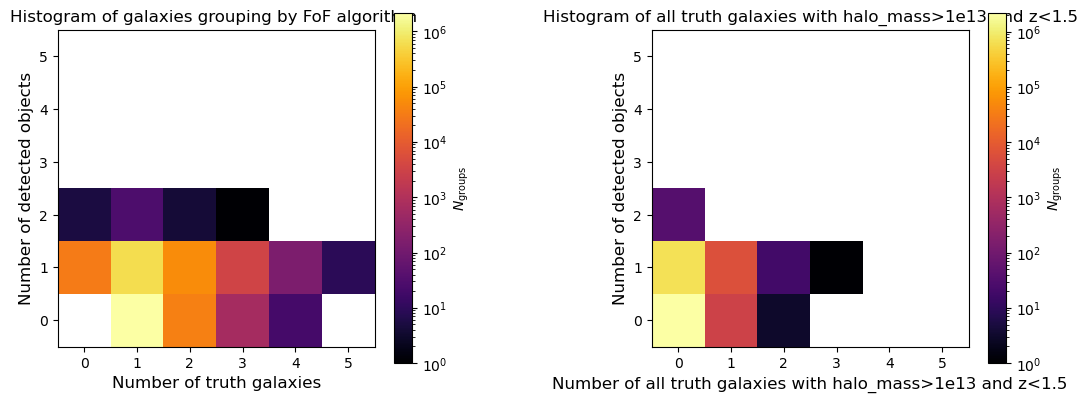

In [23]:
plt.figure(figsize=(11,10))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(221)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm(), cmap='inferno')
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxies grouping by FoF algorithm ')

plt2=plt.subplot(222)
hist2d2_2cut_all=plt.hist2d(n_truth_2cut_all, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5,
                    norm=mpl.colors.LogNorm(), cmap='inferno')
plt.xlabel('Number of all truth galaxies with halo_mass>1e13 and z<1.5', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of all truth galaxies with halo_mass>1e13 and z<1.5')

plt.show()

In [24]:
print("missed detections :")

print("nbr of (1-0) systems for all truth galaxies with z>1,5 and halo_mass>1e13=", hist2d2_2cut_all[0][1,0])

print("recognized blending :")

print("nbr of (1-1) systems =", hist2d2_2cut_all[0][1,1])

print("unrecognized blending :")

print("nbr of (2-1) systems =", hist2d2_2cut_all[0][2,1])

missed detections :
nbr of (1-0) systems for all truth galaxies with z>1,5 and halo_mass>1e13= 3073.0
recognized blending :
nbr of (1-1) systems = 6073.0
unrecognized blending :
nbr of (2-1) systems = 19.0


In [25]:
print("% of (1-0) systems in all truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_all[0][1,0]/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut))[0]]))*100)

print("% of (1-1) systems in all truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_all[0][1,1]/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut))[0]]))*100)

print("% of (2-1) systems in all truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_all[0][2,1]/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut))[0]]))*100)

% of (1-0) systems in all truth galaxies with z<1,5 and halo_mass>1e13 : 33.427607962580225
% of (1-1) systems in all truth galaxies with z<1,5 and halo_mass>1e13 : 66.06113347111932
% of (2-1) systems in all truth galaxies with z<1,5 and halo_mass>1e13 : 0.2066789948874143


## Halo_mass >1e13 + z-max-cut study for central galaxies :

In [26]:
n_truth_2cut_central = np.bincount(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut))[0]]['group_id'],
                               minlength=n_groups)

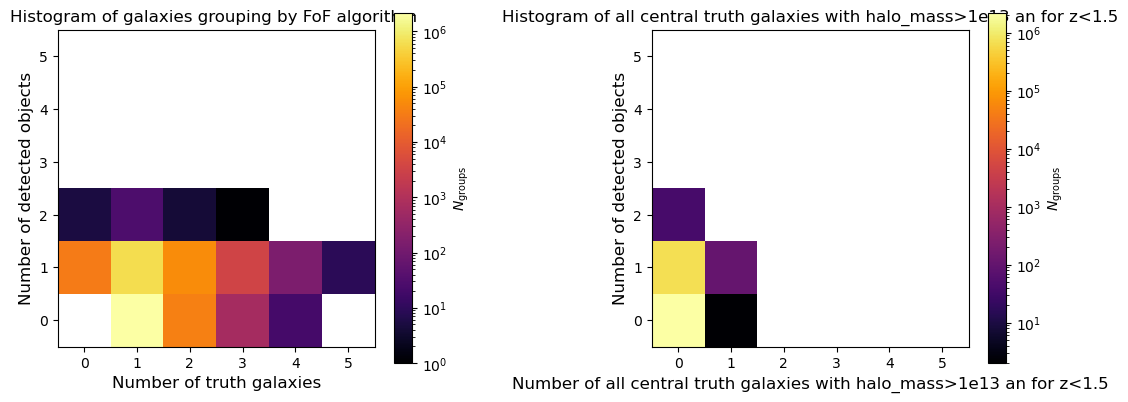

In [27]:
plt.figure(figsize=(11,10))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(221)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm(), cmap='inferno')
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxies grouping by FoF algorithm ')

plt2=plt.subplot(222)
hist2d2_2cut_central=plt.hist2d(n_truth_2cut_central, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5,
                    norm=mpl.colors.LogNorm(), cmap='inferno')
plt.xlabel('Number of all central truth galaxies with halo_mass>1e13 an for z<1.5', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of all central truth galaxies with halo_mass>1e13 an for z<1.5')

plt.show()

In [28]:
print("missed detections :")

print("nbr of (1-0) systems for all central truth galaxies with z>1,5 and halo_mass >1e13 =", hist2d2_2cut_central[0][1,0])

print("recognized blending :")

print("nbr of (1-1) systems =", hist2d2_2cut_central[0][1,1])

print("unrecognized blending :")

print("nbr of (2-1) systems =", hist2d2_2cut_central[0][2,1])

missed detections :
nbr of (1-0) systems for all central truth galaxies with z>1,5 and halo_mass >1e13 = 2.0
recognized blending :
nbr of (1-1) systems = 106.0
unrecognized blending :
nbr of (2-1) systems = 0.0


In [29]:
print("% of (1-0) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_central[0][1,0]/len(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut))[0]]))*100)

print("% of (1-1) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_central[0][1,1]/len(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut))[0]]))*100)

print("% of (2-1) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_central[0][2,1]/len(results[truth_mask][ind_galax_central][np.where((truth_data_z[ind_galax_central]<z_max_cut) & (truth_data_halo_mass[ind_galax_central]>halo_mass_cut))[0]]))*100)

% of (1-0) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 : 1.8518518518518516
% of (1-1) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 : 98.14814814814815
% of (2-1) systems in all central truth galaxies with z<1,5 and halo_mass>1e13 : 0.0


## Halo_mass >1e13 + z-max-cut study for sat galaxies :

In [30]:
n_truth_2cut_sat = np.bincount(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]>halo_mass_cut))[0]]['group_id'],
                               minlength=n_groups)

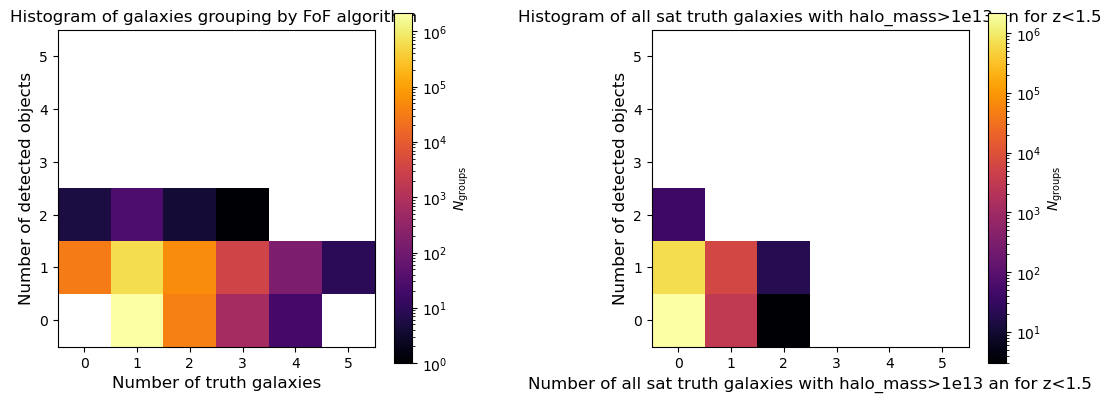

In [31]:
plt.figure(figsize=(11,10))
plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(221)
hist2d1=plt.hist2d(n_truth, n_object, bins=np.arange(max(np.max(n_object), np.max(n_truth))+2)-0.5, norm=mpl.colors.LogNorm(), cmap='inferno')
plt.xlabel('Number of truth galaxies', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of galaxies grouping by FoF algorithm ')

plt2=plt.subplot(222)
hist2d2_2cut_sat=plt.hist2d(n_truth_2cut_sat, n_object,
                    bins=np.arange(max(np.max(n_object), 
                    np.max(n_truth))+2)-0.5,
                    norm=mpl.colors.LogNorm(), cmap='inferno')
plt.xlabel('Number of all sat truth galaxies with halo_mass>1e13 an for z<1.5', fontsize=12)
plt.ylabel('Number of detected objects', fontsize=12)
plt.colorbar(label=r'$N_{\rm groups}$')
plt.gca().set_aspect('equal')
plt.title('Histogram of all sat truth galaxies with halo_mass>1e13 an for z<1.5')

plt.show()

In [32]:
print("missed detections :")

print("nbr of (1-0) systems for all sat truth galaxies with z<1,5 and halo_mass>1e13 =", hist2d2_2cut_sat[0][1,0])

print("recognized blending :")

print("nbr of (1-1) systems =", hist2d2_2cut_sat[0][1,1])

print("unrecognized blending :")

print("nbr of (2-1) systems =", hist2d2_2cut_sat[0][2,1])

missed detections :
nbr of (1-0) systems for all sat truth galaxies with z<1,5 and halo_mass>1e13 = 3071.0
recognized blending :
nbr of (1-1) systems = 5970.0
unrecognized blending :
nbr of (2-1) systems = 19.0


In [33]:
print("% of (1-0) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_sat[0][1,0]/len(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]>halo_mass_cut))[0]]))*100)

print("% of (1-1) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_sat[0][1,1]/len(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]>halo_mass_cut))[0]]))*100)

print("% of (2-1) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 :",
     (hist2d2_2cut_sat[0][2,1]/len(results[truth_mask][ind_galax_sat][np.where((truth_data_z[ind_galax_sat]<z_max_cut) & (truth_data_halo_mass[ind_galax_sat]>halo_mass_cut))[0]]))*100)

% of (1-0) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 : 33.80297193175564
% of (1-1) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 : 65.71271326362135
% of (2-1) systems in all sat truth galaxies with z<1,5 and halo_mass>1e13 : 0.20913593835993394


# (2-1) system with background galaxies (z<1,5) :

In [34]:
#selection indice de TOUTES les galaxies présentes dans les systèmes 2-1 :

system_2_1_mask_all_back1= np.in1d(results['group_id'], np.flatnonzero((n_truth == 2) & (n_object == 1)))

ind_truth_all_2_1_back1=results[system_2_1_mask_all_back1 & truth_mask]['row_index'].copy()

In [35]:
results[system_2_1_mask_all_back1]

row_index,catalog_key,group_id
int64,str6,int64
27,object,27
803522,galaxy,27
2329731,galaxy,27
72,object,72
890764,galaxy,72
1036433,galaxy,72
102,object,102
1959376,galaxy,102
2799277,galaxy,102


In [36]:
#selection indice de TOUTES les galaxies présentes dans les systèmes 2-1 avec une méthode différente mais donnant exactement le même résultat:

system_2_1_mask_all_back2= np.in1d(results[truth_mask]['group_id'], np.flatnonzero((n_truth == 2) & (n_object == 1)))

ind_truth_all_2_1_back2=results[truth_mask][system_2_1_mask_all_back2]['row_index'].copy()

In [37]:
results[truth_mask][system_2_1_mask_all_back2]

row_index,catalog_key,group_id
int64,str6,int64
803522,galaxy,27
2329731,galaxy,27
890764,galaxy,72
1036433,galaxy,72
1959376,galaxy,102
2799277,galaxy,102
1808633,galaxy,111
2825533,galaxy,111
1817369,galaxy,113


In [38]:
np.where(results[system_2_1_mask_all_back1 & truth_mask] != results[truth_mask][system_2_1_mask_all_back2])[0]

print('aucune différence entre les deux méthodes')

aucune différence entre les deux méthodes


In [39]:
n_truth_z_max_cut_all = np.bincount(results[truth_mask][np.where(truth_data['redshift'][ind_galax]<z_max_cut)[0]]['group_id'],
                                    minlength=n_groups)

#selection indice de TOUTES les galaxies (pas forcément faisant parti d'un amas mais de z<1,5) présentes dans les systèmes 2-1 :

system_2_1_mask_all_back= np.in1d(results[truth_mask][np.where((truth_data_z<z_max_cut))[0]]['group_id'], np.flatnonzero((n_truth_z_max_cut_all == 2) & (n_object == 1)))

ind_truth_all_2_1_back=results[truth_mask][np.where((truth_data_z<z_max_cut))[0]][system_2_1_mask_all_back]['row_index'].copy()

In [40]:
results[truth_mask][np.where((truth_data_z<z_max_cut))[0]][system_2_1_mask_all_back]

row_index,catalog_key,group_id
int64,str6,int64
890764,galaxy,72
1036433,galaxy,72
1817369,galaxy,113
2010983,galaxy,113
479187,galaxy,133
1769250,galaxy,133
1069908,galaxy,153
1707463,galaxy,153
490483,galaxy,154


In [41]:
#selection of systems with at least one of the 2 galaxies belonging to a cluster :

ind_truth_all_2_1_back_good=np.zeros(len(ind_truth_all_2_1_back))
i=0
for i in  tqdm(np.arange(0,len(ind_truth_all_2_1_back), 2)) :
    i+=2
    if ((truth_data['halo_mass'][ind_truth_all_2_1_back[i-2]] > halo_mass_cut) or (truth_data['halo_mass'][ind_truth_all_2_1_back[i-1]] > halo_mass_cut)) :
        ind_truth_all_2_1_back_good[i-2]=ind_truth_all_2_1_back[i-2]
        ind_truth_all_2_1_back_good[i-1]=ind_truth_all_2_1_back[i-1]

  0%|          | 0/29723 [00:00<?, ?it/s]

In [42]:
ind_truth_all_2_1_back_good=ind_truth_all_2_1_back_good[np.where(ind_truth_all_2_1_back_good != 0)[0]].copy()

len(ind_truth_all_2_1_back_good)

660

In [43]:
print("% of (2-1) systems (with at least 1 of the 2 galaxies of the system belonging to a cluster) in all clusters with z<1,5 =", (len(ind_truth_all_2_1_back_good)/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut))[0]]))*100)

% of (2-1) systems (with at least 1 of the 2 galaxies of the system belonging to a cluster) in all clusters with z<1,5 = 7.179375611878604


In [44]:
#selection of system with 2 galaxies belonging to a cluster :

ind_truth_all_2_1_back_good2=np.zeros(len(ind_truth_all_2_1_back2))
i=0
for i in tqdm(np.arange(0,len(ind_truth_all_2_1_back2), 2)) :
    i+=2
    if ((truth_data['halo_mass'][ind_truth_all_2_1_back2[i-2]] > halo_mass_cut) & (truth_data['halo_mass'][ind_truth_all_2_1_back2[i-1]] > halo_mass_cut)) :
        ind_truth_all_2_1_back_good2[i-2]=ind_truth_all_2_1_back2[i-2]
        ind_truth_all_2_1_back_good2[i-1]=ind_truth_all_2_1_back2[i-1]

  0%|          | 0/54858 [00:00<?, ?it/s]

In [45]:
ind_truth_all_2_1_back_good2=ind_truth_all_2_1_back_good2[np.where(ind_truth_all_2_1_back_good2 != 0)[0]].copy()

len(ind_truth_all_2_1_back_good2)

36

In [46]:
print("% of (2-1) systems (with the two galaxies at z<1,5 belonging to a cluster) in the different clusters =", (len(ind_truth_all_2_1_back_good2)/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut))[0]]))*100)

% of (2-1) systems (with the two galaxies at z<1,5 belonging to a cluster) in the different clusters = 0.39160230610246927


# (2-1) system with ALL background galaxies :

In [47]:
n_truth_all = np.bincount(results[truth_mask][ind_galax]['group_id'], minlength=n_groups)

#selection indice de TOUTES les galaxies (pas forcément faisant parti d'un amas mais de z<1,5) présentes dans les systèmes 2-1 :

system_2_1_mask_all_back3= np.in1d(results[truth_mask]['group_id'], np.flatnonzero((n_truth_all == 2) & (n_object == 1)))

ind_truth_all_2_1_back3=results[truth_mask][system_2_1_mask_all_back3]['row_index'].copy()

In [48]:
results[truth_mask][system_2_1_mask_all_back3]

row_index,catalog_key,group_id
int64,str6,int64
803522,galaxy,27
2329731,galaxy,27
890764,galaxy,72
1036433,galaxy,72
1959376,galaxy,102
2799277,galaxy,102
1808633,galaxy,111
2825533,galaxy,111
1817369,galaxy,113


In [49]:
#selection of systems with at least one of the 2 galaxies belonging to a cluster :

ind_truth_all_2_1_back_good3=np.zeros(len(ind_truth_all_2_1_back3))

for i in tqdm(np.arange(0,len(ind_truth_all_2_1_back3), 2)) :
    
    i+=2
    
    if ((truth_data['halo_mass'][ind_truth_all_2_1_back3[i-2]] > halo_mass_cut) & (truth_data['redshift'][ind_truth_all_2_1_back3[i-2]] < 1.5)) :
        
        ind_truth_all_2_1_back_good3[i-2]=ind_truth_all_2_1_back3[i-2]
        ind_truth_all_2_1_back_good3[i-1]=ind_truth_all_2_1_back3[i-1]
        
    if ((truth_data['halo_mass'][ind_truth_all_2_1_back3[i-1]] > halo_mass_cut) & (truth_data['redshift'][ind_truth_all_2_1_back3[i-1]] < 1.5)) :
        
        ind_truth_all_2_1_back_good3[i-2]=ind_truth_all_2_1_back3[i-2]
        ind_truth_all_2_1_back_good3[i-1]=ind_truth_all_2_1_back3[i-1]

  0%|          | 0/54858 [00:00<?, ?it/s]

In [50]:
ind_truth_all_2_1_back_good3=ind_truth_all_2_1_back_good3[np.where(ind_truth_all_2_1_back_good3 != 0)[0]].copy()

len(ind_truth_all_2_1_back_good3)

922

In [51]:
print("% of (2-1) systems (with one of the two galaxies belonging to a cluster) in the different clusters =", (len(ind_truth_all_2_1_back_good3)/len(results[truth_mask][np.where((truth_data_z<z_max_cut) & (truth_data_halo_mass>halo_mass_cut))[0]]))*100)

% of (2-1) systems (with one of the two galaxies belonging to a cluster) in the different clusters = 10.029370172957686


### Selection of the brightest stars in the system :

In [52]:
ind_truth_all_2_1_back_good3= results[truth_mask][np.in1d(results[truth_mask]['row_index'],ind_truth_all_2_1_back_good3)]['row_index'].copy() #pour repasser dans type dictio

In [53]:
results[truth_mask][np.in1d(results[truth_mask]['row_index'],ind_truth_all_2_1_back_good3)]

row_index,catalog_key,group_id
int64,str6,int64
522830,galaxy,20284
1005910,galaxy,20284
613024,galaxy,22818
2793639,galaxy,22818
607150,galaxy,27536
964713,galaxy,27536
607129,galaxy,27738
2715197,galaxy,27738
607218,galaxy,27822


In [54]:
brightest_galaxies= [] #np.zeros(len(ind_truth_all_2_1_back3_good3))
faintest_galaxies= [] #np.zeros(len(ind_truth_all_2_1_back3_good3))

for i in tqdm(np.arange(0, len(ind_truth_all_2_1_back_good3), 2)):
    i+=2
    if (truth_data['mag_i'][ind_truth_all_2_1_back_good3[i-2]] < truth_data['mag_i'][ind_truth_all_2_1_back_good3[i-1]]) :
        brightest_galaxies.append(ind_truth_all_2_1_back_good3[i-2])
        faintest_galaxies.append(ind_truth_all_2_1_back_good3[i-1])
        
    if (truth_data['mag_i'][ind_truth_all_2_1_back_good3[i-2]] > truth_data['mag_i'][ind_truth_all_2_1_back_good3[i-1]]) :
        brightest_galaxies.append(ind_truth_all_2_1_back_good3[i-1])
        faintest_galaxies.append(ind_truth_all_2_1_back_good3[i-2])

  0%|          | 0/461 [00:00<?, ?it/s]

In [55]:
brightest_galaxies=np.array(brightest_galaxies)

print(type(brightest_galaxies))

<class 'numpy.ndarray'>


In [56]:
ind_brightest_galaxies=results[truth_mask][np.in1d(results[truth_mask]['row_index'], brightest_galaxies)]['row_index']

In [57]:
faintest_galaxies=np.array(faintest_galaxies)
ind_faintest_galaxies=results[truth_mask][np.in1d(results[truth_mask]['row_index'], faintest_galaxies)]['row_index']

In [58]:
print(type(faintest_galaxies))

<class 'numpy.ndarray'>


# i-Mag studies :

In [59]:
# object selection :

ind_object_2_1_all_good= results[object_mask][np.in1d(results[object_mask]['group_id'], results[truth_mask][np.in1d(results[truth_mask]['row_index'], brightest_galaxies)]['group_id'])]['row_index']

## Brightest galaxies :

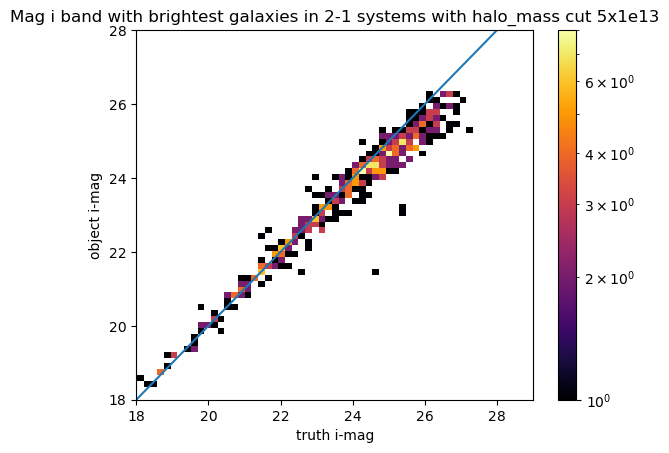

In [64]:
hist2d_mag=plt.hist2d(truth_data['mag_i'][ind_brightest_galaxies],
                      object_data['mag_i_cModel'][ind_object_2_1_all_good], 
                      bins=50, 
                      norm=mpl.colors.LogNorm(), cmap='inferno');
plt.axline([0,0], slope=1)
plt.colorbar()
plt.xlabel("truth i-mag")
plt.ylabel("object i-mag")
plt.xlim(18,29)
plt.ylim(18,28)
plt.title("Mag i band with brightest galaxies in 2-1 systems with halo_mass cut 5x1e13")
plt.savefig('2-1_system_blending_studies_with_background_5x1e13/Mag i band with brightest galaxies in 2-1 systems')
plt.show()

## Faintest galaxies :

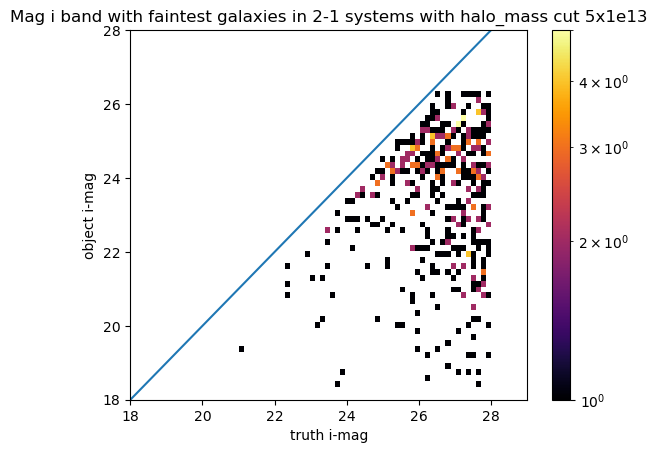

In [65]:
hist2d_mag=plt.hist2d(truth_data['mag_i'][ind_faintest_galaxies],
                      object_data['mag_i_cModel'][ind_object_2_1_all_good], 
                      bins=50, 
                      norm=mpl.colors.LogNorm(), cmap='inferno');
plt.axline([0,0], slope=1)
plt.colorbar()
plt.xlabel("truth i-mag")
plt.ylabel("object i-mag")
plt.xlim(18,29)
plt.ylim(18,28)
plt.title("Mag i band with faintest galaxies in 2-1 systems with halo_mass cut 5x1e13")
plt.savefig('2-1_system_blending_studies_with_background_5x1e13/Mag i band with faintest galaxies in 2-1 systems')
plt.show()

## Redshift distribution :

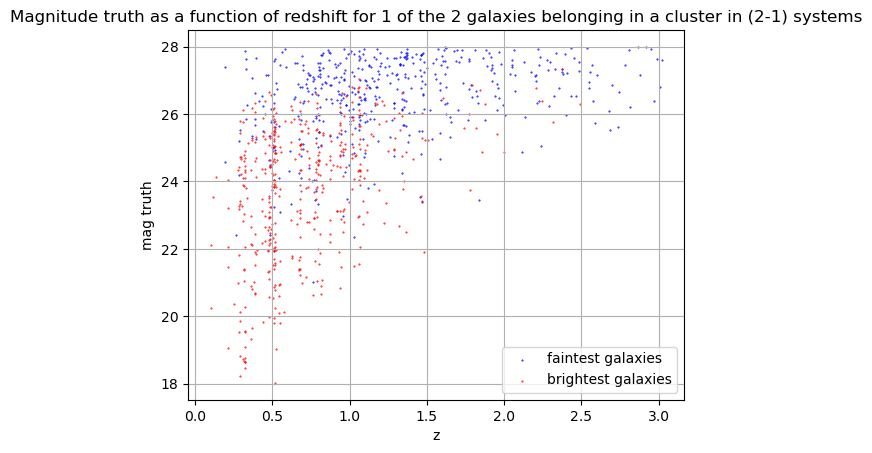

In [66]:
plt.figure()
plt.scatter(truth_data['redshift'][ind_faintest_galaxies], truth_data['mag_i'][ind_faintest_galaxies], s=0.2, label='faintest galaxies', color='blue')
plt.scatter(truth_data['redshift'][ind_brightest_galaxies], truth_data['mag_i'][ind_brightest_galaxies], s=0.2, label='brightest galaxies', color='red')
plt.xlabel('z')
plt.ylabel('mag truth')
plt.title('Magnitude truth as a function of redshift for 1 of the 2 galaxies belonging in a cluster in (2-1) systems')
plt.legend()
plt.grid()
plt.savefig('2-1_system_blending_studies_with_background_5x1e13/Magnitude truth as a function of redshift for 1 of the 2 galaxies belonging in a cluster in (2-1) systems')
plt.show()

## Halo_mass distribution :

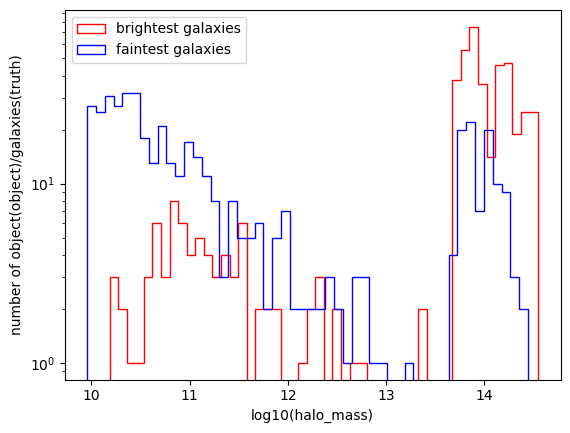

In [67]:
plt.figure()
plt.hist(np.log10(truth_data['halo_mass'][ind_brightest_galaxies]), bins=50, 
                            histtype='step', label='brightest galaxies', log=True, color='red')
plt.hist(np.log10(truth_data['halo_mass'][ind_faintest_galaxies]), bins=50,
                            histtype='step', label='faintest galaxies', log=True, color='blue')
plt.legend()
plt.xlabel('log10(halo_mass)')
plt.ylabel('number of object(object)/galaxies(truth)')
plt.xticks()
plt.yticks()
plt.savefig('2-1_system_blending_studies_with_background_5x1e13/Histo halo_mass sat central')
plt.show()